# Семинар №4 

In [1]:
import numpy as np
import cv2 
import skimage.exposure
import skimage.io
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [3]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

# Матрицы смежности. Gray-Level Co-Occurrence Matrix (GLCM)
 
Давайте искать неоднородности и разделять текстуры!

<img src="https://i.ibb.co/y6FMPLX/image--022.jpg" alt="Drawing" style="width: 400px;"/> 

Матрица совпадений – это статистический метод исследования текстуры изображения в градациях серого. Рассмотрии $I(k,k)$ изображение в градациях серого относительно центрального пикселя $(n_c, m_c)$. Значения совпадения определяется как распределение значений совпадений на данном расстоянии от определенного пикселя $(n_c, m_c)$. Для изображения $I(k,k)$ матрица совпадений $C_M=C_{(D_x, D_y)}(k,k) $определяется как:

$C_M = \sum_{k}^{n=1}\sum_{k}^{m=1} \begin{cases} 1, if \ I(n,m)=k \ and \ I(n+D_x, m+D_y)=k \\ 0, \ otherwise \end{cases}$

где $D_x$, $D_y$ параметр сдвига, задающий взаимное расположение пикселей и определятся следующим образом:

$D_x = D cos(\theta)$, $D_y = D sin(\theta)$, а $\theta$ – смещение, которое определяет направление матрицы от центрального пикселя и расстояние от центрального пикселя, как показано на рисунке

$I(n,m)$ – уровень яркости пикселя изображения, расположенного в точке $(n, m)$.

<img src="img/co-matrix_expl.jpg" alt="Drawing" style="width: 400px;"/> 

## Матрицы смежности: характиристики

1. $Contrast = \sum_{i,j=0}^{levels-1} C_{i,j}(i-j)^2$

Контраст является мерой локального изменения интенсивности, отдавая предпочтение значениям от диагонали (i = j). Чем больше значение, тем больше различие в значениях интенсивности среди соседних пикселей.

2. $Dissimilarity = \sum_{i,j=0}^{levels-1}C_{i,j}|i-j|$

Отражает меру несимметричности элементов в GLCM

3. $Homogeneity = \sum_{i,j=0}^{levels-1}\frac{C_{i,j}}{1+(i-j)^2}$

Отражает близость распределения элементов в GLCM

4. $Energy = \sum_{i,j=0}^{levels-1} C_{i,j}^2$

Энергия является мерой однородных структур на изображении. Большая энергия подразумевает, что в изображении появляется больше пар значений интенсивности, которые соседствуют друг с другом на более высоких частотах.

5. $Aautocorrelation = \sum_{i,j=0}^{levels-1} C_{i,j}ij$

Автокорреляция является мерой величины тонкости и грубости текстуры.

6. $Entropy = - \sum_{i,j=0}^{levels-1}C_{i,j}log_{2}C_{i,j}$ 

Совместная энтропия - это мера случайности / изменчивости значений интенсивности соседства.

7. $Difference \ Entropy = \sum_{k=0}^{levels-2} C_{x-y}(k)log_{2}(C_{x-y}(k) + \epsilon$

Разностная Энтропия является мерой случайности / изменчивости в разнице значений интенсивности окрестности.

8. $Correlation = \sum_{i,j=0}^{levels-1} C_{i,j}\left[\frac{(i-\mu_i) \
(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$, где

    $\mu_i = \sum_{i=1}^{L}\sum_{j=1}^{L}iC_M$ 

    $\mu_j = \sum_{i=1}^{L}\sum_{j=1}^{L}jC_M$, 

    $\sigma_{i}^2 = \sum_{i=1}^{L}\sum_{j=1}^{L}C_M(i-\mu_{i}^2)$

    $\sigma_{j}^2 = \sum_{i=1}^{L}\sum_{j=1}^{L}C_M(j-\mu_{j}^2)$
    
    Корреляция - это значение между 0 (некоррелированный) и 1 (идеально коррелированный), показывающее линейную зависимость значений уровня серого от их соответствующих пикселей в GLCM.
    
9. $Cluster \ Prominence = \sum_{i,j=0}^{levels-1} (i + j - \mu_{x} - \mu_{y})^4 C_{i,j}$

Распространенность кластеров - это мера асимметрии и асимметрии GLCM. Более высокие значения подразумевают большую асимметрию относительно среднего, в то время как более низкое значение указывает на пик около среднего значения и меньшую вариацию относительно среднего.

10. $Cluster \ Shade = \sum_{i,j=0}^{levels-1} (i + j - \mu_{x} - \mu_{y})^3 C_{i,j}$

Кластерный оттенок - это показатель асимметрии и однородности GLCM. Более высокий оттенок кластера подразумевает большую асимметрию относительно среднего значения.

11. $Cluster \ Tendency = \sum_{i,j=0}^{levels-1} (i + j - \mu_{x} - \mu_{y})^2 C_{i,j} $

Кластерная Тенденция - это мера группирования вокселей с одинаковыми значениями уровня серого.

12. $Joint \ Average = \mu_{x} = \sum_{i,j=0}^{levels-1} C_{i,j}i$

Совместное Среднее - средняя интенсивность уровня серого распределения i.

13. $Difference \ Average = \sum_{k=0}^{levels-2} kC_{x-y}(k)$

$ C_{x-y}(k) = \sum_{i,j=0}^{levels-1} C_{i,j}$, где $|i-j| = k$ и $k = 0, 1, ..., levels - 2$.

Среднее различие измеряет взаимосвязь между появлением пар с одинаковыми значениями интенсивности и появлением пар с различными значениями интенсивности.

14. $Difference \ Variance = \sum_{k=0}^{levels-2} (k-DA)^2 C_{x-y}(k)$

Разница является мерой неоднородности, которая помещает более высокие веса в пары различных уровней интенсивности, которые больше отклоняются от среднего.


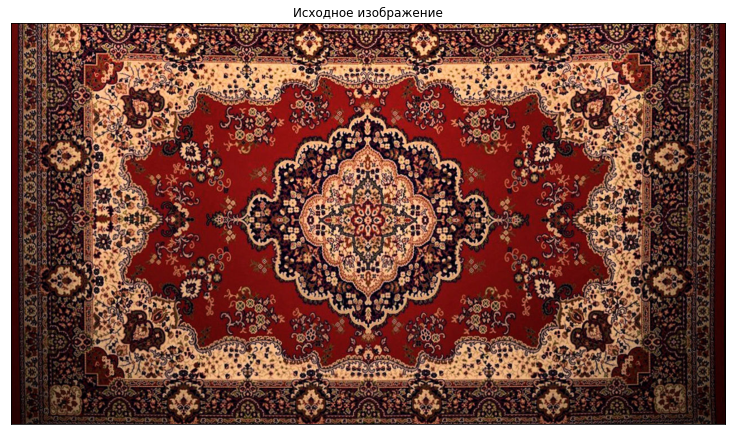

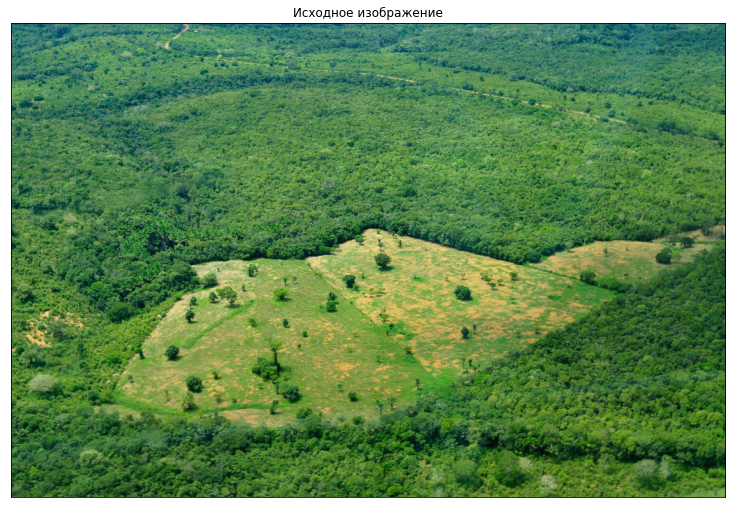

In [4]:
carpet = cv2.imread('img/carpet_ex.jpg')
carpet = cv2.cvtColor(carpet, cv2.COLOR_BGR2RGB)
forest = cv2.imread('img/forest_ex.jpg')
forest = cv2.cvtColor(forest, cv2.COLOR_BGR2RGB)

plot_one_image(carpet)
plot_one_image(forest)

In [5]:
from skimage.feature import greycomatrix

gray_carpet = cv2.cvtColor(carpet, cv2.COLOR_RGB2GRAY)
glcm = greycomatrix(gray_carpet, [2, 16], [0, np.pi/2],
                    normed=False, symmetric=False, levels=256)

In [6]:
gray_carpet[:4, :4]

array([[45, 38, 37, 38],
       [43, 37, 36, 38],
       [42, 35, 36, 38],
       [42, 35, 36, 39]], dtype=uint8)

In [7]:
glcm[:4, :4, 0, 0]

array([[ 16,  66,  70,  48],
       [ 61, 238, 251, 249],
       [ 66, 257, 266, 243],
       [ 55, 240, 274, 285]], dtype=uint32)

In [8]:
glcm[:4, :4, 1, 0]

array([[ 1, 13, 22,  9],
       [18, 63, 74, 69],
       [13, 65, 83, 81],
       [17, 64, 74, 98]], dtype=uint32)

Некоторые характеристики реализваоны в ```skimage.feature.greycoprops```:
- *Contrast*

- *Dssimilarity*

- *Hmogeneity*

- *ASM*

- *Eergy*

- *Crrelation*

In [9]:
from skimage.feature import greycoprops

feature = greycoprops(glcm, prop='contrast')
feature

array([[2222.72398061, 2087.83418567],
       [4806.95791359, 4881.1888461 ]])

# Контуры на изображении

## Производная в виде свертки

На прошлом лекции, мы рассмотрели операцию свёртки и отметили, что свёртка — это очень полезная и распространённая операция, лежащая в основе различных фильтров. 

Одна из важнейших свёрток $-$ это вычисление производных. 
В математике и физике производные играют очень важную роль, то же самое можно сказать и про компьютерное зрение.
Но что же это за производная от изображения? Как мы помним, изображения, с которыми мы работаем, состоят из пикселей, которые, для картинки в градациях серого, задают значение яркости.
Т.е. изображение $-$ это просто двумерная матрица чисел. Теперь вспомним, что же такое производная.

**Производная (функции в точке)** $-$ это скорость изменения функции (в данной точке). Определяется как предел отношения приращения функции к приращению ее аргумента при стремлении приращения аргумента к нулю.


Получается, что, в нашем случае, производная — это отношение значения приращения пикселя по y к значению приращению пикселя по x: $dI = \frac{dy}{dx}$

Работая с изображением I, мы работает с функцией двух переменных $I(x,y)$, т.е. со скалярным полем. Поэтому, более правильно говорить не о производной, а о градиенте изображения.


## Градиент

Вспомним такое поняте __градиент__ — вектор, своим направлением указывающий направление наибольшего возрастания некоторой величины ${\displaystyle \varphi}$. Это очень важное свойство, которое помогает искать минимумы и максимумы функций нескольких переменных. Осознание данного утверждения потребуется нам дальше на летней смене. 

Давйте рассмотрим графическую интерпретацию на картинке ниже. Видно, что стрелки идут от синей области к красной, т.е. красная область — пик максимума (вершина), а синяя — минимум (яма).

<img src="https://d.radikal.ru/d28/1905/e5/9a65c30ea355.jpg" width="500">

Для случая трёхмерного пространства градиентом скалярной функции ${\displaystyle \varphi =\varphi (x,y,z)}$ координат ${\displaystyle x}, {\displaystyle y}, {\displaystyle z}$ называется векторная функция с компонентами ${\displaystyle \frac  {\partial \varphi }{\partial x}},{\displaystyle \frac  {\partial \varphi }{\partial y}},{\displaystyle \frac  {\partial \varphi }{\partial z}}$ и обозначается ${\displaystyle \nabla \varphi =\left({\frac {\partial \varphi }{\partial x}},\;{\frac {\partial \varphi }{\partial y}},\;{\frac {\partial \varphi }{\partial z}}\right).}$

Если ${\displaystyle \varphi }$  — функция ${\displaystyle n}$ переменных ${\displaystyle x_{1},\;\ldots ,\;x_{n}}$, то её градиентом называется ${\displaystyle n}$-мерный вектор ${\displaystyle \left({\frac {\partial \varphi }{\partial x_{1}}},\;\ldots ,\;{\frac {\partial \varphi }{\partial x_{n}}}\right),} $ компоненты которого равны частным производным ${\displaystyle \varphi }$ по всем её аргументам.

Если каждой точке M области многомерного пространства поставлено в соответствие некоторое (обычно $-$ действительное) число $u$, то говорят, что в этой области задано скалярное поле.


Итак, градиент для каждой точки изображения (функция яркости) — двумерный вектор, компонентами которого являются производные яркости изображения по горизонтали и вертикали $-$ $grad[I(x,y)] = (\frac{dI}{dx}, \frac{dI}{dy})$

В каждой точке изображения градиентный вектор ориентирован в направлении наибольшего увеличения яркости, а его длина соответствует величине изменения яркости.

вектор (в заданной точке) задаётся двумя значениями: длиной и направлением.

* длинной: $\sqrt{dx^2 + dy^2}$;

* направление $-$ угол между вектором и осью $x$: $\tan^{-1}(\frac{dy}{dx})$;

## Оператор Собеля

**Оператор Собеля** $-$ это дискретный дифференциальный оператор, вычисляющий приближение градиента яркости изображения.
Оператор вычисляет градиент яркости изображения в каждой точке. Так находится направление наибольшего увеличения яркости и величина её изменения в этом направлении. Результат показывает, насколько «резко» или «плавно» меняется яркость изображения в каждой точке, а значит, вероятность нахождения точки на грани, а также ориентацию границы.

Т.о. результатом работы оператора Собеля в точке области постоянной яркости будет нулевой вектор, а в точке, лежащей на границе областей различной яркости — вектор, пересекающий границу в направлении увеличения яркости.

Наиболее часто оператор Собеля применяется в алгоритмах выделения границ. 

Оператор Собеля основан на свёртке изображения небольшими целочисленными фильтрами в вертикальном и горизонтальном направлениях, поэтому его относительно легко вычислять. Оператор использует ядра 3x3, с которыми свёртывают исходное изображение для вычисления приближенных значений производных по горизонтали и по вертикали.


### Формализация
Пусть ${\displaystyle \mathbf {A} }$ $-$ это исходное изображение, а ${\displaystyle \mathbf {G} _{x}}$ и ${\displaystyle \mathbf {G} _{y}}$ $-$ два изображения, на которых каждая точка содержит приближённые производные по ${\displaystyle x}$ и по ${\displaystyle y}$. Они вычисляются следующим образом:

${\displaystyle \mathbf {G} _{y}={\begin{bmatrix}-1&-2&-1\\0&0&0\\+1&+2&+1\\\end{bmatrix}}*\mathbf {A} \quad {\mbox{and}}\quad \mathbf {G} _{x}={\begin{bmatrix}-1&0&+1\\-2&0&+2\\-1&0&+1\end{bmatrix}}*\mathbf {A} }$

## Контур и как его найти

**Контурный анализ** $-$ это один из важных и очень полезных методов описания, хранения, распознавания, сравнения и поиска графических образов/объектов. 

**Контур** $-$ это внешние очертания (обвод) предмета/объекта.

При проведении контурного анализа:
* полагается, что контур содержит достаточную информацию о форме объекта;
* внутренние точки объекта во внимание не принимаются. 

Вышеприведённые положения, разумеется, накладывают существенные ограничения на область применения контурного анализа, которые, в основном, связаны с проблемами выделения контура на изображениях:
* из-за одинаковой яркости с фоном объект может не иметь чёткой границы, или может быть зашумлён помехами, что приводит к невозможности выделения контура;
* перекрытие объектов или их группировка приводит к тому, что контур выделяется неправильно и не соответствует границе объекта.

Однако, переход к рассмотрению только контуров объектов позволяет уйти от пространства изображения – к пространству контуров, что существенно снижает сложность алгоритмов и вычислений. 

Т.о., контурный анализ имеет довольно слабую устойчивость к помехам, и любое пересечение или лишь частичная видимость объекта приводит либо к невозможности детектирования, либо к ложным срабатываниям, но простота и быстродействие контурного анализа, позволяют вполне успешно применять данный подход (при чётко выраженном объекте на контрастном фоне и отсутствии помех).

Итак, мы определились, что контур — это некая граница объекта, которая отделяет его от фона (других объектов). 

Во всех случаях мы получаем бинарное изображение, которое явным образом задаёт нам границы объекта. Вот эта совокупность пикселей, составляющих границу объекта и есть контур объекта.

Чтобы оперировать полученным контуром, его необходимо как-то представить (закодировать). 
Например, указывать вершины отрезков, составляющих контур.
Другой известный способ кодирования контура $-$ это **цепной код Фримена**. Этот метод будет рассмотрен чуть позже.

## Оператор Лапласа
Он вычисляет лапласиан изображения, заданного соотношением,
${\Delta src = \frac{\partial ^2{src}}{\partial x^2} + \frac{\partial ^2{src}}{\partial y^2}}$
где каждая производная находится с использованием производных Собеля. Если ksize = $3$, то для фильтрации используется следующее ядро:

$$
{K = \begin{pmatrix}
0 & \ 1 & \ 0 \\ 
1 & \ -4 & \ 1 \\ 
0 & \ 1 & \ 0 
\end{pmatrix}}$$

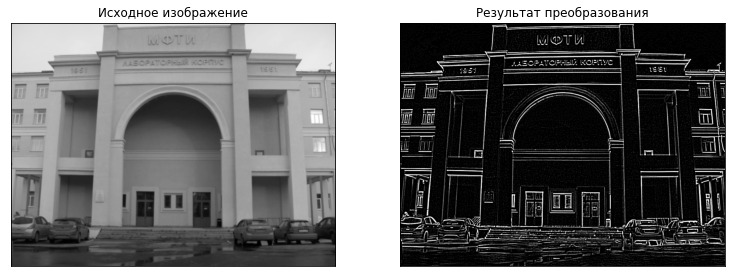

In [10]:
img = cv2.imread('img/lk.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## выделяем границы
gray_img = cv2.GaussianBlur(gray_img, ksize=(7, 7), sigmaX=1, sigmaY=1)
laplac = cv2.Laplacian(gray_img, cv2.THRESH_BINARY, scale=0.55, ksize=5)

plot_transform_result(gray_img, laplac, is_gray=True)

## Детектор границ Кенни (Canny)

### Теория
**Canny Edge Detection** $-$ популярный алгоритм обнаружения краев. Это многоступенчатый алгоритм, и мы пройдем через все этапы.

1. **Шумоподавление**

Поскольку обнаружение краев подвержено воздействию шума на изображении, первым шагом является удаление шума на изображении с помощью фильтра Гаусса $5\times5$. Мы уже видели это в предыдущих главах.

2. **Поиск градиента интенсивности изображения**

Затем сглаженное изображение фильтруется ядром Собеля (рассмотрен выше) в горизонтальном и вертикальном направлении, чтобы получить первую производную в горизонтальном направлении ($G_x$) и вертикальном направлении ($G_y$). Из этих двух изображений мы можем найти градиент края и направление для каждого пикселя следующим образом:

$${Edge(G) = \sqrt{ G_x^2 + G_y^2}}$$
$${Angle(\theta) = \tan^{-1}(\frac{G_x}{G_y})}$$

Направление градиента всегда перпендикулярно краям. Он округлен до одного из четырех углов, представляющих вертикальное, горизонтальное и два диагональных направления.

3. **Немаксимальное подавление**

После получения величины и направления градиента выполняется полное сканирование изображения для удаления любых нежелательных пикселей, которые могут не составлять края. Для этого в каждом пикселе пиксель проверяется, является ли он локальным максимумом в его окрестности в направлении градиента. Проверьте изображение ниже:

<img src="https://i.ibb.co/XZZVNmK/nms.jpg" alt="Drawing" style="width: 500px;"/> 

Точка $А$ находится на краю (в вертикальном направлении). Направление градиента нормальное к краю. Точки $B$ и $C$ находятся в градиентных направлениях. Таким образом, точка $A$ проверяется с помощью точек $B$ и $C$, чтобы увидеть, образует ли она локальный максимум. Если это так, он рассматривается для следующего этапа, в противном случае он подавляется (обнуляется).

Короче говоря, в результате вы получите бинарное изображение с «тонкими краями».

4. **Подбор порогового значения**

Эта стадия решает, какие ребра действительно являются ребрами, а какие нет. Для этого нам понадобятся два пороговых значения, **minVal** и **maxVal**. Любые ребра с градиентом интенсивности, превышающим **maxVal**, обязательно будут ребрами, а ребра ниже **minVal** не будут ребрами, поэтому отбрасываются. Те, кто лежит между этими двумя порогами, классифицируются как ребра или не ребра в зависимости от их связности. Если они связаны с точными пикселями, они считаются частью ребер. В противном случае они также отбрасываются. Смотрите изображение ниже:

<img src="https://i.ibb.co/cryRqvD/hysteresis.jpg" alt="Drawing" style="width: 500px;"/> 

Край $A$ выше **maxVal**, так что считается «верным краем». Хотя ребро $C$ меньше **maxVal**, оно связано с ребром $A$, так что это также считается допустимым ребром, и мы получаем эту полную кривую. Но ребро $B$, хотя оно выше **minVal** и находится в той же области, что и ребро $C$, не связано с каким-либо «верным краем», поэтому отбрасывается. Поэтому очень важно, чтобы мы выбрали соответственно **minVal** и **maxVal**, чтобы получить правильный результат.

На этом этапе также удаляются небольшие пиксельные шумы в предположении, что края являются длинными линиями.

Итак, что мы в итоге получаем, это сильные края изображения.

## Детектор границ Кенни в OpenCV
OpenCV помещает все вышеперечисленное в одну функцию ```cv2.Canny(image,threshold1,threshold2,apertureSize,L2gradient)```. 

* **image** $-$ это наше входное изображение
* **threshold1** $-$ minVal для процедуры гистерезиса
* **threshold2** $-$ maxVal для процедуры гистерезиса
* **apertureSize** $-$ размер ядра Собеля, используемый для поиска градиентов изображения, по умолчанию равен $3$
* **L2gradient** $-$ флаг, определяет уравнение для определения величины градиента. Если это True, он использует упомянутое выше уравнение, которое является более точным, в противном случае он использует эту функцию: Edge_Gradient($G$) = |$G_x$| + |$G_y$|. По умолчанию это False.

In [11]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

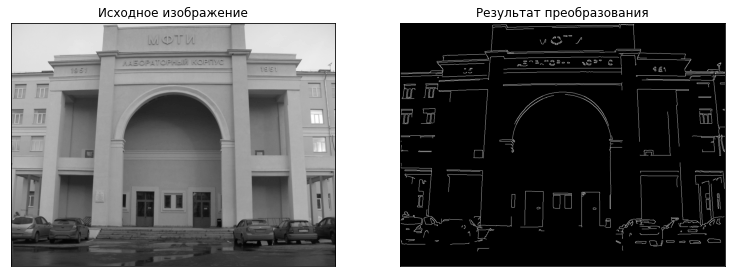

In [12]:
img = cv2.imread('img/lk.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

edges = auto_canny(blurred)

plot_transform_result(gray, edges, is_gray=True)

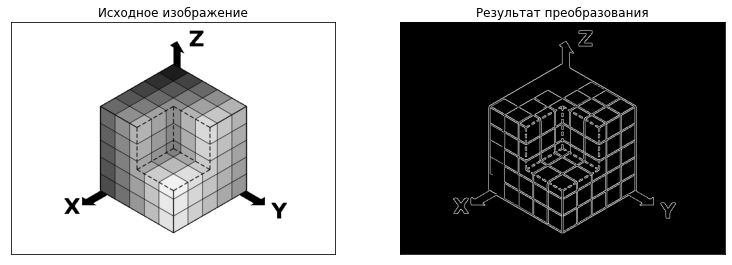

In [13]:
img = cv2.imread('img/RGB_cube.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 1)

edges = auto_canny(blurred)

plot_transform_result(gray, edges, is_gray=True)

## Оператор Laplacian of Gaussian (LoG) 

Мы узнали, как использовать оператор Собеля. Это было основано на том факте, что в краевой области интенсивность пикселей показывает «скачок» или большое изменение интенсивности. Получив первую производную интенсивности, мы заметили, что ребро характеризуется максимумом, как это видно на рисунке:

<img src="img/Laplace_Operator_Tutorial_Theory_Previous.jpg" alt="Drawing" style="width: 500px;"/> 


И ... что произойдет, если мы возьмем вторую производную?

<img src="img/Laplace_Operator_Tutorial_Theory_ddIntensity.jpg" alt="Drawing" style="width: 300px;"/> 


Вы можете заметить, что вторая производная равна нулю. Таким образом, мы также можем использовать этот критерий, чтобы попытаться обнаружить края на изображении. Однако обратите внимание, что нули будут появляться не только по краям (они могут фактически появляться в других бессмысленных местах); это может быть решено путем применения фильтрации там, где это необходимо.

### Laplacian Operator

Из приведенного выше объяснения мы делаем вывод, что вторая производная может использоваться для поиска ребер. Поскольку изображения $2D$, нам нужно взять производную в обоих измерениях. Здесь удобен оператор Лапласа, который определяется:

${Laplace(f) = \Delta {f} = \frac{\partial ^2{f}}{\partial x^2} + \frac{\partial ^2{f}}{\partial y^2}}$


Оператор Лапласа реализован в OpenCV функцией ```cv2.Laplacian()```. Фактически, поскольку лапласиан использует градиент изображений, он вызывает внутренний оператор Собеля для выполнения своих вычислений.

### Шаги для фильтра LoG:

* Применить LoG на изображение, Это можно сделать двумя способами:
     * Сначала примените гауссовский, а затем лапласианский или
     * Конвертировать изображение с помощью ядра LoG напрямую
* Найти нулевые пересечения в изображении
* Отобрать по порогу пересечения нуля, чтобы извлечь только "сильные" края.

### Немного математики

Для начала посмотрим на LoG. Уже поняли, что такое оператор лапласа или (лапласиан), на прошлом занятии уже рассмотрели гауссиану $G_{\sigma}(x,y)=\frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$. 

**Вопрос:** чему равно $\Delta{G_{sigma}}= \ ?$

### Практика

1. Чему равно $\Delta{G_{\sigma}}= \ ?$ (аналитический вид)

2. Постройте графики $G_{\sigma}(x,y)$, $\frac{\partial {G(x, y)}}{\partial {x}}$, $\Delta{G_{sigma}(x, y)}$ при $x \in [-7, 7]$

In [14]:
# Ваш код

### Перейдем к реализации фильтра 

In [15]:
def LoG_filter(image, kernel_size=5, sigma=0):
    # применить гауссов фильтр
    blur = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    # применить лапласиан
    laplacian = cv2.Laplacian(blur, cv2.CV_64F, kernel_size, delta=sigma)

    # глобальная нормировка на максимум
    laplacian1 = laplacian / laplacian.max()
    
    z_c_image = np.zeros(image.shape)
    
    # для каждого пикселя считаем количество положительных и отрицательных значений
    neighbour_size = 1
    for i in range(neighbour_size, image.shape[0] - neighbour_size):
        for j in range(neighbour_size, image.shape[1] - neighbour_size):
            negative_count = 0
            positive_count = 0
            # соседи
            neighbour = [laplacian1[i+1, j-1],
                         laplacian1[i+1, j],
                         laplacian1[i+1, j+1],
                         laplacian1[i, j-1],
                         laplacian1[i, j+1],
                         laplacian1[i-1, j-1],
                         laplacian1[i-1, j],
                         laplacian1[i-1, j+1]]
            d = np.max(neighbour)
            e = np.min(neighbour)
            for h in neighbour:
                if h > 0:
                    positive_count += 1
                elif h < 0:
                    negative_count += 1


            # Если и отрицательные, и положительные значения существуют в 
            # районе пикселя, тогда этот пиксель - это потенциальный нулевой переход
            
            z_c = ((negative_count > 0) and (positive_count > 0))
            
            # Измениnm значение пикселя на максимальное по соседству разницу с пикселем
            if z_c:
                if image[i,j] > 0:
                    z_c_image[i, j] = image[i,j] + np.abs(e)
                elif image[i,j] < 0:
                    z_c_image[i, j] = np.abs(image[i,j]) + d
                
    # нормилизация на 255
    z_c_norm = z_c_image / z_c_image.max() * 255
    z_c_image = np.uint8(z_c_norm)

    return z_c_image

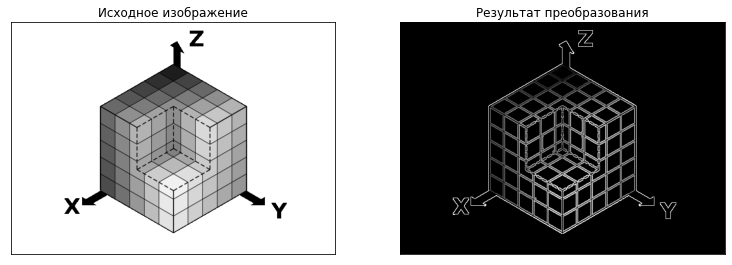

In [16]:
img = cv2.imread('img/RGB_cube.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = LoG_filter(gray)

plot_transform_result(gray, edges, is_gray=True)

## Оператор Difference of Gaussians (DoG) 

Учитывая $m$ - канал, $n$ - мерное изображение

$I:\{\mathbb{X}\subseteq\mathbb{R}^n\}\rightarrow\{\mathbb{Y}\subseteq\mathbb{R}^m\}$

Разность гауссианов (DoG) изображения $I$ - это функция

$\Gamma_{\sigma_1,\sigma_2}:\{\mathbb{X}\subseteq\mathbb{R}^n\}\rightarrow\{\mathbb{Z}\subseteq\mathbb{R}\}$

полученный путем вычитания изображения $I$, свернутого с дисперсией Гаусса $\sigma^2_2$, из изображения $I$, свернутого с гауссианом более узкой дисперсии $\sigma^2_1 $, с $\sigma_2 > \sigma_1$. В одном измерении $\Gamma$ определяется как:

$\Gamma_{\sigma_1,\sigma_2}(x)=I*\frac{1}{\sigma_1\sqrt{2\pi}} \, e^{-(x^2)/(2\sigma^2_1)}-I*\frac{1}{\sigma_2\sqrt{2\pi}} \, e^{-(x^2)/(2\sigma_2^2)}.$

### Практика

1. Постройте графики $G_{\sigma_1}$ и $G_{\sigma_2}$
2. Примените DoG filter по аналогии с LoG
3. Сравните результаты применения LoG и DoG

In [17]:
# Ваш код

## Выделяем контуры

Полученные границы достаточно просто преобразуются в контуры. Для алгоритма Кэнни это происходит автоматически, для остальных алгоритмов требуется дополнительная бинаризация. Получить контур для бинарного алгоритма можно например алгоритмом [жука](http://wiki.technicalvision.ru/index.php/%D0%92%D1%8B%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BE%D0%BD%D1%82%D1%83%D1%80%D0%BE%D0%B2).

В OpenCV поиск контуров похож на поиск белого объекта на черном фоне. Помните, что объект, который нужно найти, должен быть белым, а фон должен быть черным.
Давайте посмотрим, как найти контуры двоичного изображения с помощью метода **Фридмана**:

**Цепной код Фримена (Фридмана) (Freeman Chain Code)**

Цепные коды применяются для представления границы в виде последовательности отрезков прямых линий определённой длины и направления. В основе этого представления лежит 4- или 8- связная решётка. Длина каждого отрезка определяется разрешением решётки, а направления задаются выбранным кодом.
(для представления всех направлений в 4-связной решётке достаточно 2-х бит, а для 8-связной решётки цепного кода требуется 3 бита)

<img src="https://i.ibb.co/6tyGLKS/freeman_chain_code.png" alt="Drawing" style="width: 300px;"/> 

Если честно, то у меня ни разу ни получилось применить контурный анализ в реальных задачах. Уж слишком идеальные условия требуются. То граница не найдётся, то шумов слишком много. Но, если нужно что-то распознавать в идеальных условиях $-$ то контурный анализ замечательный вариант. Очень быстро работает, красивая математика и понятная логика.

В OpenCV для поиска контуров имеется функцией findContours, которая имеет вид:

```findContours(img, hierarchy, mode, method, offset)```


1. img — должным образом подготовленная для анализа картинка. Это должно быть 8-битное изображение. Поиск контуров использует для работы монохромное изображение, так что все пиксели картинки с ненулевым цветом будут интерпретироваться как 1, а все нулевые останутся нулями.


2. mode — один из четырех режимов группировки найденных контуров:
    * CV_RETR_LIST — выдаёт все контуры без группировки;
    * CV_RETR_EXTERNAL — выдаёт только крайние внешние контуры. Например, если в кадре будет пончик, то функция вернет его внешнюю границу без дырки.
    * CV_RETR_CCOMP — группирует контуры в двухуровневую иерархию. На верхнем уровне — внешние контуры объекта. На втором уровне — контуры отверстий, если таковые имеются. Все остальные контуры попадают на верхний уровень.
    * CV_RETR_TREE — группирует контуры в многоуровневую иерархию.


3. method — один из трёх методов упаковки контуров:
    * CV_CHAIN_APPROX_NONE — упаковка отсутствует и все контуры хранятся в виде отрезков, состоящих из двух пикселей.
    * CV_CHAIN_APPROX_SIMPLE — склеивает все горизонтальные, вертикальные и диагональные контуры.
    * CV_CHAIN_APPROX_TC89_L1,CV_CHAIN_APPROX_TC89_KCOS — применяет к контурам метод упаковки (аппроксимации) Teh-Chin.


4. hierarchy — список всех найденных контуров, представленных в виде векторов; иерархия — информация о топологии контуров. Каждый элемент иерархии представляет собой сборку из четырех индексов, которая соответствует контуру[i]:
    * иерархия[i][0] — индекс следующего контура на текущем слое;
    * иерархия[i][1] — индекс предыдущего контура на текущем слое:
    * иерархия[i][2] — индекс первого контура на вложенном слое;
    * иерархия[i][3] — индекс родительского контура.


5. offset — величина смещения точек контура. Это полезно, если контуры извлекаются из ROI, а затем они должны анализироваться во всем контексте изображения.

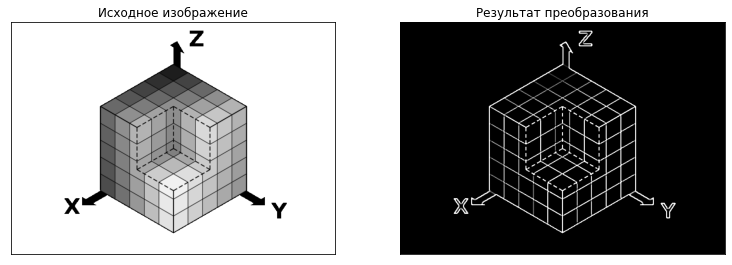

In [18]:
img = cv2.imread('img/RGB_cube.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

laplac = cv2.Laplacian(gray_img, cv2.THRESH_BINARY, scale=0.15, ksize=5)
laplac = cv2.medianBlur(laplac, 3)
contours, hierarchy = cv2.findContours(laplac, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plot_transform_result(gray, laplac, is_gray=True)

## Как нарисовать контуры?

Для рисования контуров используется функция:

```drawContours(image, contours, contourIdx, color, thickness, lineType, hierarchy, maxLevel, offset)```

1. image — кадр, поверх которого мы будем отрисовывать контуры; 


2. contours — те самые контуры, найденные функцией findContours; 


3. contourIdx — индекс контура, который следует отобразить. 
    * -1 — если нужно отобразить все контуры; 


4. color — цвет контура; 


5. thickness — толщина линии контура; 


6. lineType — тип соединения точек вектора; 


7. hierarchy — информация об иерархии контуров; 


8. maxLevel — индекс слоя, который следует отображать. 
    * Если параметр равен 0, то будет отображен только выбранный контур. Если параметр равен 1, то отобразится выбранный контур и все его дочерние контуры. Если параметр равен 2, то отобразится выбранный контур, все его дочерние и дочерние дочерних! И так далее. 
    

9. offset — величина смещения точек контура.

Его также можно использовать для рисования любой фигуры, если у вас есть граничные точки. Его первый аргумент является исходным изображением, второй аргумент - это контуры, которые должны быть переданы в виде списка Python, третий аргумент - это индекс контуров (полезно при рисовании отдельного контура. Чтобы нарисовать все контуры, передайте -1), а остальные аргументы - это цвет, толщина и т.п.

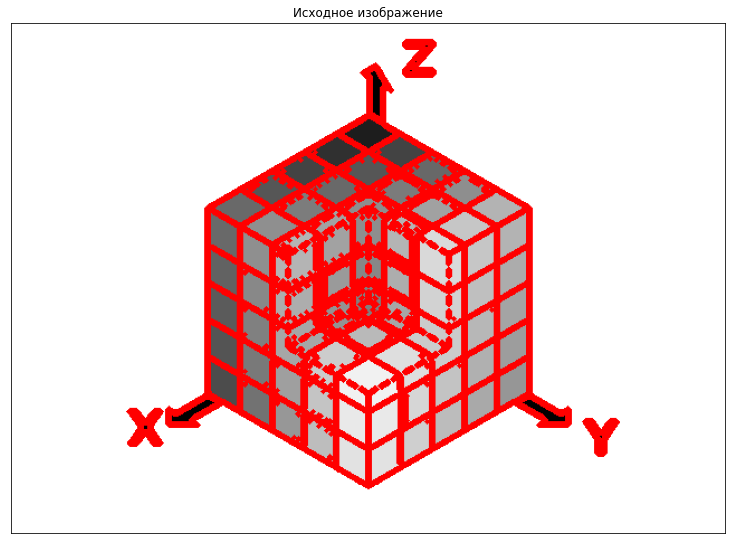

In [19]:
# нарисуем все найденные контуры
img1 = gray_img.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img1, contours, -1, (255, 0, 0), 3)

plot_one_image(img1)

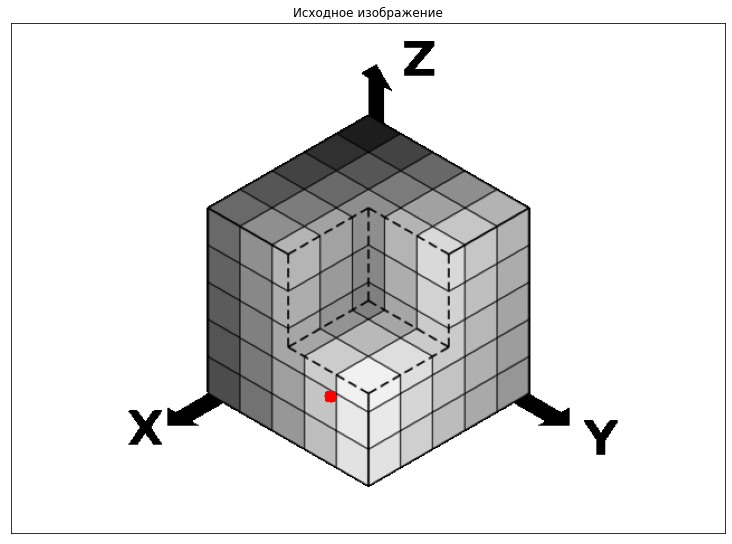

In [20]:
# нарисуем один выбранный контур
img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img2, contours, 53, (255, 0, 0), 10)

plot_one_image(img2)

# Ключевые признаки контура

Пройдемся по основным методам работы с характеристиками конутра, которые доступны в OpenCV.

## Моменты
Моменты изображения помогают вам рассчитать некоторые функции, такие как центр масс объекта, площадь объекта и т. д.

Функция **cv2.moments()** предоставляет словарь всех вычисленных значений моментов.

__Центральные моменты__

$\mu _{{pq}}=\sum _{{x}}\sum _{{y}}(x-{\bar  {x}})^{p}(y-{\bar  {y}})^{q}f(x,y)$

__Масштабные инварианты__

Инварианты $η_{ij}$ относительно сдвига и масштаба могут быть построены из центральных моментов путем деления на правильно масштабированный нулевой центральный момент:

${\displaystyle \eta _{ij}={\frac {\mu _{ij}}{\mu _{00}^{\left(1+{\frac {i+j}{2}}\right)}}}\}\$, 
где i + j ≥ 2. Обратите внимание, что трансляционная инвариантность непосредственно следует только за счет использования центральных моментов.

__Вращающиеся инварианты__

Как показано в работе Ху, могут быть построены инварианты относительно перемещения, масштаба и вращения:

${\displaystyle I_{1}=\eta _{20}+\eta _{02}} I_{1}=\eta _{{20}}+\eta _{{02}}$

${\displaystyle I_{2}=(\eta _{20}-\eta _{02})^{2}+4\eta _{11}^{2}} I_{2}=(\eta _{{20}}-\eta _{{02}})^{2}+4\eta _{{11}}^{2}$

${\displaystyle I_{3}=(\eta _{30}-3\eta _{12})^{2}+(3\eta _{21}-\eta _{03})^{2}} I_{3}=(\eta _{{30}}-3\eta _{{12}})^{2}+(3\eta _{{21}}-\eta _{{03}})^{2}$

${\displaystyle I_{4}=(\eta _{30}+\eta _{12})^{2}+(\eta _{21}+\eta _{03})^{2}} I_{4}=(\eta _{{30}}+\eta _{{12}})^{2}+(\eta _{{21}}+\eta _{{03}})^{2}$

${\displaystyle I_{5}=(\eta _{30}-3\eta _{12})(\eta _{30}+\eta _{12})[(\eta _{30}+\eta _{12})^{2}-3(\eta _{21}+\eta _{03})^{2}]+(3\eta _{21}-\eta _{03})(\eta _{21}+\eta _{03})[3(\eta _{30}+\eta _{12})^{2}-(\eta _{21}+\eta _{03})^{2}]}$

${\displaystyle I_{6}=(\eta _{20}-\eta _{02})[(\eta _{30}+\eta _{12})^{2}-(\eta _{21}+\eta _{03})^{2}]+4\eta _{11}(\eta _{30}+\eta _{12})(\eta _{21}+\eta _{03})}$

${\displaystyle I_{7}=(3\eta _{21}-\eta _{03})(\eta _{30}+\eta _{12})[(\eta _{30}+\eta _{12})^{2}-3(\eta _{21}+\eta _{03})^{2}]-(\eta _{30}-3\eta _{12})(\eta _{21}+\eta _{03})[3(\eta _{30}+\eta _{12})^{2}-(\eta _{21}+\eta _{03})^{2}].}$

${\displaystyle I_{8}=\eta _{11}[(\eta _{30}+\eta _{12})^{2}-(\eta _{03}+\eta _{21})^{2}]-(\eta _{20}-\eta _{02})(\eta _{30}+\eta _{12})(\eta _{03}+\eta _{21})}$

${\displaystyle I_{8}=\eta _{11}[(\eta _{30}+\eta _{12})^{2}-(\eta _{03}+\eta _{21})^{2}]-(\eta _{20}-\eta _{02})(\eta _{30}+\eta _{12})(\eta _{03}+\eta _{21})}$

Они хорошо известны как инварианты моментов Ху.

Первый, I1, аналогичен моменту инерции вокруг центроида изображения, где интенсивности пикселей аналогичны физической плотности. Последний, I7, является косоинвариантным, что позволяет ему отличать зеркальные изображения от других идентичных изображений.

In [21]:
img = cv2.imread('img/RGB_cube.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

laplac = cv2.Laplacian(gray_img, cv2.THRESH_BINARY, scale=1, ksize=5)
laplac = cv2.medianBlur(laplac, 3)
contours, hierarchy = cv2.findContours(laplac, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[100]
M = cv2.moments(cnt)
print(M)

{'m00': 1311.5, 'm10': 374766.8333333333, 'm01': 398632.6666666666, 'm20': 107282145.91666666, 'm11': 113859163.54166666, 'm02': 121296141.75, 'm30': 30765924110.45, 'm21': 32578689349.933334, 'm12': 34629362207.566666, 'm03': 36948216401.3, 'mu20': 190892.1105710119, 'mu11': -51856.01600690186, 'mu02': 131061.35825181007, 'mu30': 487463.8866844177, 'mu21': -266107.6853415072, 'mu12': -14792.28963728249, 'mu03': 374144.60594940186, 'nu20': 0.1109817043087488, 'nu11': -0.030148281235367454, 'nu02': 0.07619703540547573, 'nu30': 0.007825673232243896, 'nu21': -0.0042720534729982955, 'nu12': -0.00023747323282847146, 'nu03': 0.006006462238016428}


In [22]:
# Коэффициент асимметрии
import math
sigma_x = math.sqrt(M['m20']/M['m00'])
sigma_y = math.sqrt(M['m02']/M['m00'])

k_x = M['m30']/sigma_x**3
k_y = M['m03']/sigma_y**3

print(k_x, k_y)

1315.0165812314067 1313.637206903704


Из этих моментов вы можете извлечь полезные данные, такие как площадь, центроид и т.д. Центроид определяется отношениями, ${C_x = \frac{M_{10}}{M_{00}}}$ and ${C_y = \frac{M_{01}}{M_{00}}}$.

Cx = 285 Cy = 303


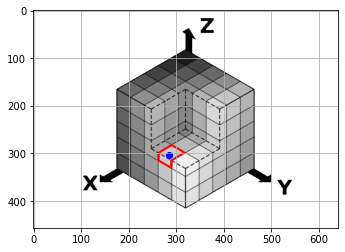

In [23]:
Cx = int(M['m10'] /M ['m00'])
Cy = int(M['m01'] / M['m00'])
print('Cx =', Cx, 'Cy =', Cy)

img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cnt = contours[100]
cv2.drawContours(img2, [cnt], 0, (255, 0, 0), 3)
plt.scatter(Cx, Cy, color='blue')

plt.grid()
plt.imshow(img2);

Чтобы рассчитать все моменты Ху есть функция ```cv2.HuMoments(moments)````

In [24]:
hu = cv2.HuMoments(M)

print(hu)

[[ 1.87178740e-01]
 [ 4.84564864e-03]
 [ 4.27190155e-04]
 [ 6.05889530e-05]
 [-2.39526259e-09]
 [ 3.11159000e-07]
 [-9.44879754e-09]]


__Пример сохранения моментов__

<img src="https://i.ibb.co/1nL7q4w/HuMoments.png" alt="Drawing" style="width: 600px;"/> 

### Расстояние между двумя фигурами с помощью matchShapes

В этом разделе мы узнаем, как использовать моменты Ху, чтобы найти расстояние между двумя фигурами. Если расстояние маленькое, формы близки по внешнему виду, а если расстояние большое, то фигуры находятся дальше друг от друга по внешнему виду.

OpenCV предоставляет простую в использовании служебную функцию matchShapes, которая берет два изображения (или контура) и находит расстояние между ними с помощью Hu Moments. Таким образом, вам не нужно явно вычислять моменты Ху. Просто оцифруйте изображения и используйте matchShapes.

Использование показано ниже.

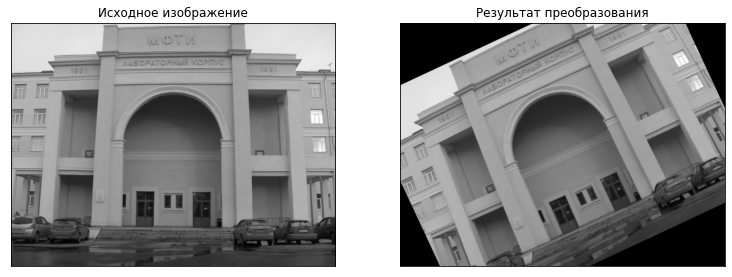

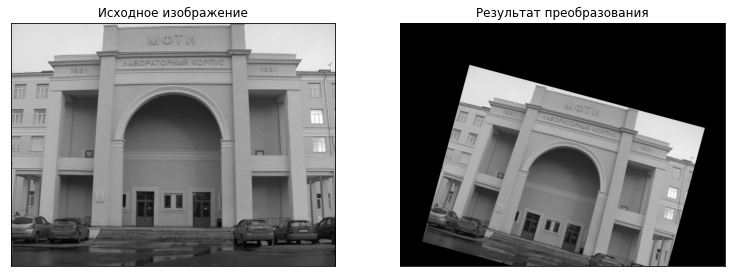

In [25]:
img = cv2.imread('img/lk.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rows, cols = img.shape

M1 = cv2.getRotationMatrix2D((cols/2, rows/2), 25, scale=1.0)
M2 = cv2.getRotationMatrix2D((300, 700), -15, scale=0.75)

dst1 = cv2.warpAffine(img.copy(), M1, (cols, rows))
dst2 = cv2.warpAffine(img.copy(), M2, (cols, rows))

plot_transform_result(img, dst1, is_gray=True)
plot_transform_result(img, dst2, is_gray=True)

In [26]:
d1 = cv2.matchShapes(dst1, dst2, cv2.CONTOURS_MATCH_I1,0)
d2 = cv2.matchShapes(dst1, dst2, cv2.CONTOURS_MATCH_I2,0)
d3 = cv2.matchShapes(dst1, dst2, cv2.CONTOURS_MATCH_I3,0)

print(f'Расстояние по I1: {d1:.5f}\n'
      f'Расстояние по I2: {d2:.5f}\n'
      f'Расстояние по I3: {d3:.5f}')

Расстояние по I1: 0.00023
Расстояние по I2: 0.00191
Расстояние по I3: 0.00067


Обратите внимание, что есть три вида расстояний, которые можно использовать с помощью третьего параметра (CONTOURS_MATCH_I1, CONTOURS_MATCH_I2 или CONTOURS_MATCH_I3).

Два изображения (im1 и im2) похожи, если указанные выше расстояния малы. Вы можете использовать любую меру расстояния. Они обычно дают похожие результаты.

Давайте посмотрим, как определяются эти три расстояния.

Пусть $ D (A, B) $ - расстояние между формами $ A $ и $ B $, а $ H ^ A_i $ и $ H ^ B_i $ - логарифмические преобразования $ i ^ {th} $ Ху Моментов для фигур $ A $ и $ B $. Расстояния, соответствующие трем случаям, определяются как

CONTOURS_MATCH_I1
   \begin{align*} D(A, B) = \sum^{6}_{i=0} \left | \frac{1}{H^B_i} - \frac{1}{H^A_i} \right |  \end{align*}

CONTOURS_MATCH_I2
   \begin{align*} D(A, B) = \sum^{6}_{i=0} \left | H^B_i - H^A_i \right |  \end{align*}

CONTOURS_MATCH_I3
   \begin{align*} D(A, B) = \sum^{6}_{i=0} \frac{\left | H^A_i - H^B_i \right |}{\left | H^A_i \right |}  \end{align*}

### Custom distance measure
Если вы хотите определить собственную меру расстояния между двумя фигурами, вы можете легко это сделать. Например, вы можете использовать евклидово расстояние между моментами Ху, заданными

  \begin{align*} D(A, B) = \sqrt { \sum^{6}_{i=0} \left ( H^B_i - H^A_i \right )^2 } \end{align*}

Сначала вы вычисляете трансформированные в журнал моменты Ху, как упомянуто в предыдущем разделе, а затем сами вычисляете расстояние вместо использования matchShapes.

## Контурная зона
Площадь контура задается функцией **cv2.contourArea()** или из моментов, **M['m00']**.

In [27]:
area = cv2.contourArea(cnt)
print(area)

1311.5


## Периметр контура
Это также называется длиной дуги. Это можно узнать с помощью функции **cv2.arcLength()**. Второй аргумент указывает, является ли фигура замкнутым контуром (если передан True) или просто кривой.

In [28]:
perimeter = cv2.arcLength(cnt, True)
print(round(perimeter, 3))

165.581


## Контурное приближение
Он приближает форму контура к другой форме с меньшим количеством вершин в зависимости от заданной нами точности. Это реализация алгоритма Дугласа-Пекера. Проверьте страницу википедии на алгоритм и демонстрацию.

Чтобы понять это, предположим, что вы пытаетесь найти квадрат на изображении, но из-за некоторых проблем на изображении вы получили не идеальный квадрат, а "плохую форму" (как показано на первом изображении ниже). Теперь вы можете использовать эту функцию для аппроксимации формы. В этом случае второй аргумент называется эпсилон, который является максимальным расстоянием от контура до приближенного контура. Это параметр точности. Для правильного вывода необходим мудрый выбор эпсилона.

<img src="https://i.ibb.co/jHvc2HS/approx.jpg" alt="Drawing" style="width: 600px;"/> 

Выше, на втором изображении, зеленая линия показывает приблизительную кривую для эпсилона = $10$% длины дуги. Третье изображение показывает то же самое для эпсилона = $1$% длины дуги. Третий аргумент указывает, является ли кривая замкнутой или нет.

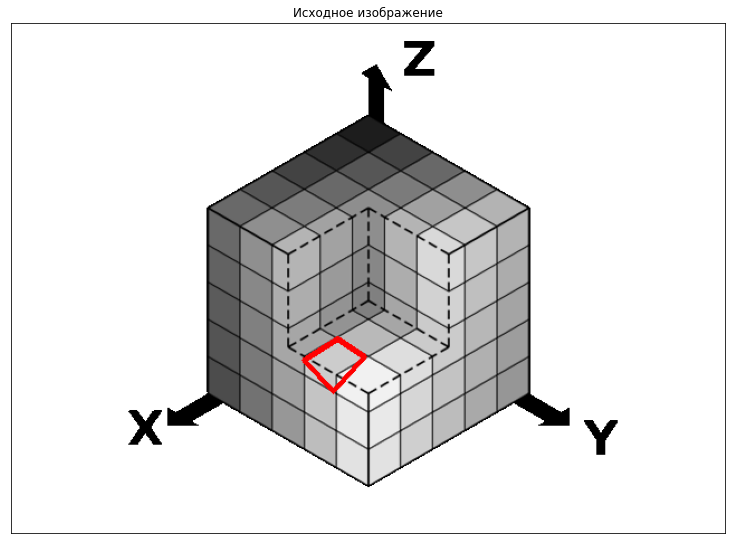

In [29]:
epsilon = 0.1 * cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img2, [approx], 0, (255, 0, 0), 3)

plot_one_image(img2)

## Выпуклость контура
Выпуклая оболочка будет похожа на контурную аппроксимацию, но это не так (оба могут давать одинаковые результаты в некоторых случаях). Здесь функция **cv2.convexHull()** проверяет кривую на наличие дефектов выпуклости и исправляет ее. Вообще говоря, выпуклые кривые $-$ это кривые, которые всегда выпуклые или, по крайней мере, плоские. И если он выпуклый внутри, это называется дефектами выпуклости. Например, проверьте изображение ниже. Красная линия показывает выпуклый корпус руки. Двусторонние стрелки показывают дефекты выпуклости, которые представляют собой локальные максимальные отклонения корпуса от контуров.
<img src="https://i.ibb.co/Z2nPDCM/convexitydefects.jpg" alt="Drawing" style="width: 300px;"/> 
**hull = cv2.convexHull(points, clockwise, returnPoints)**

* **points** $-$ точки контура.

* **clockwise** $-$ флаг ориентации. Если это правда, выходной выпуклый корпус ориентирован по часовой стрелке. В противном случае он ориентирован против часовой стрелки.

* **returnPoints** $-$ по умолчанию True. Затем он возвращает координаты точек корпуса. Если False, он возвращает индексы точек контура, соответствующие точкам корпуса.

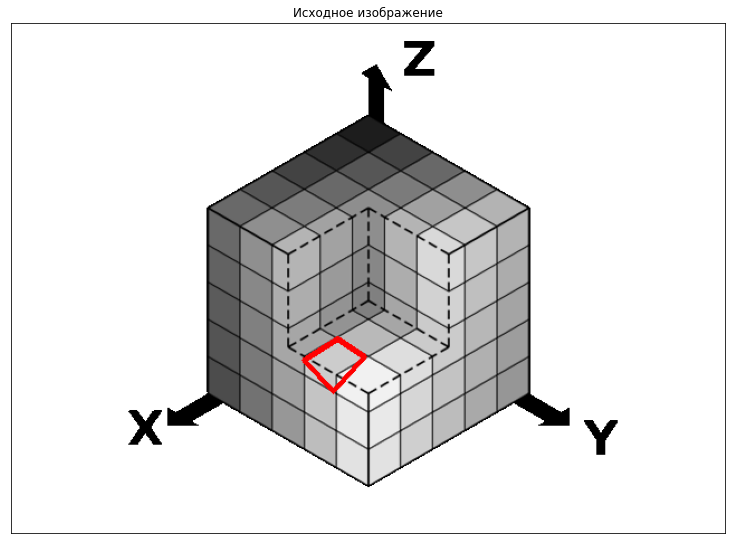

In [30]:
hull = cv2.convexHull(cnt)
hull_id = cv2.convexHull(cnt, returnPoints=False)

plot_one_image(img2)

Но если вы хотите найти дефекты выпуклости, вам нужно передать returnPoints = False.

### Проверка выпуклости
Есть функция, чтобы проверить, является ли кривая выпуклой или нет, **cv2.isContourConvex()**. Это просто возвращает True или False

Подумайте, как это можно сделать без этой функции?

In [31]:
k = cv2.isContourConvex(cnt)
print(k)

False


## Ограничивающий прямоугольник


### Прямой ограничивающий прямоугольник
Это прямой прямоугольник, он не учитывает вращение объекта. Таким образом, площадь ограничивающего прямоугольника не будет минимальной. Он находится функцией **cv2.boundingRect()**.

Пусть $(x,y)$ $-$ верхняя левая координата прямоугольника, а $(w,h)$ $-$ его ширина и высота.

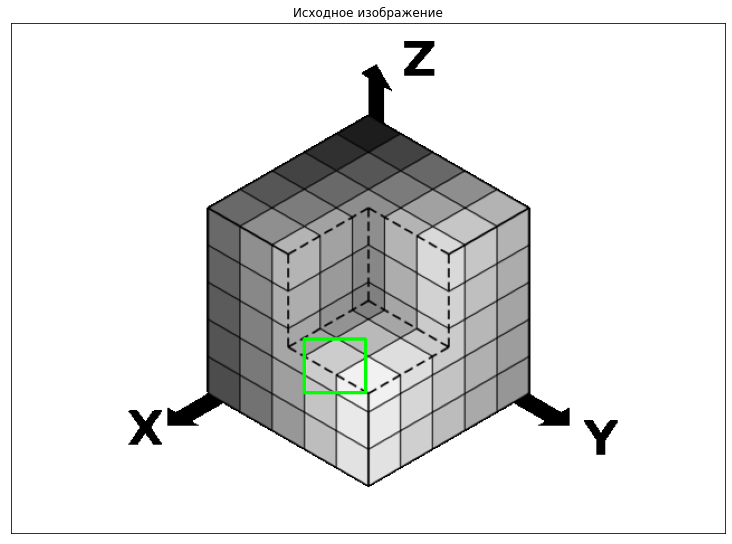

In [32]:
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_one_image(img2)

## Повернутый прямоугольник
Здесь ограничивающий прямоугольник рисуется с минимальной площадью, поэтому он учитывает и вращение. Используемая функция $-$ **cv2.minAreaRect()**. Он возвращает структуру **Box2D**, которая содержит следующие детали $-$ (центр $(x, y)$, (ширина, высота), угол поворота). Но чтобы нарисовать этот прямоугольник, нам нужно $4$ угла прямоугольника. Получается функцией **cv2.boxPoints()**.

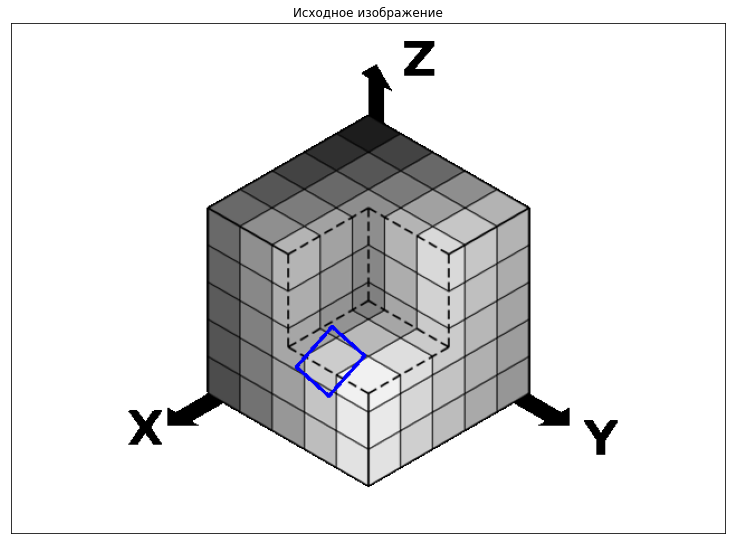

In [33]:
img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)


rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img2, [box], 0, (0, 0, 255), 2)

plot_one_image(img2)

## Подгонка линии
Точно так же мы можем подогнать линию к набору точек. Ниже изображение содержит набор белых точек. Мы можем приблизить к нему прямую линию.

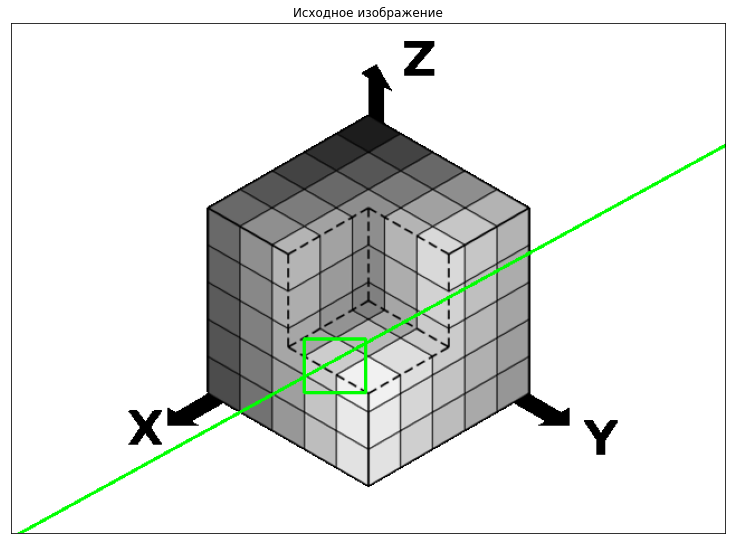

In [34]:
img2 = gray_img.copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

rows, cols = img.shape[:2]
vx, vy, x, y = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01)
lefty = int((-x * vy/ vx) + y)
righty = int(((cols - x) * vy / vx) + y)
cv2.line(img2, (cols-1, righty), (0, lefty), (0, 255, 0), 2)

x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_one_image(img2)

## Свойства контура

### Соотношение сторон
Это отношение ширины к высоте ограничивающего прямоугольника объекта.

${AspectRatio = \frac{Width}{Height}}$

In [35]:
x, y, w, h = cv2.boundingRect(cnt)
aspect_ratio = float(w) / h

print(aspect_ratio)

1.1458333333333333


### Степень
Степень $-$ это отношение площади контура к площади ограничивающего прямоугольника.

${Extent=\frac{Object\ Area}{Bounding\ Rectangle\ Area}}$

In [36]:
area = cv2.contourArea(cnt)
x, y, w, h = cv2.boundingRect(cnt)
rect_area = w * h
extent = float(area) / rect_area

print(extent)

0.496780303030303


### Solidity

Solidity $-$ это отношение площади контура к его площади выпуклой оболочки.

$Solidity = \frac{Contour \ Area}{Convex \ Hull \ Area}$


In [37]:
area = cv2.contourArea(cnt)
hull = cv2.convexHull(cnt)
hull_area = cv2.contourArea(hull)
solidity = float(area) / hull_area

print(solidity)

0.8631128660743665


### Эквивалентный диаметр

Эквивалентный диаметр $-$ это диаметр круга, площадь которого равна площади контура.

$Equivalent \ Diameter = \sqrt{\frac{4 \cdot \ Contour \ Area}{\pi}}$

In [38]:
area = cv2.contourArea(cnt)
equi_diameter = np.sqrt(4 * area / np.pi)

### Ориентация
Ориентация $-$ это угол, под которым направлен объект. Следующий метод также дает длины **Major Axis** и **Minor Axis**.


In [39]:
(x, y), (MA, ma), angle = cv2.fitEllipse(cnt)

print(x, y, MA, ma, angle)

286.34576416015625 304.59033203125 36.83538055419922 51.10971450805664 60.55577087402344


### Маска и пиксельные точки
В некоторых случаях нам могут понадобиться все точки, которые составляют этот объект. Это можно сделать следующим образом:


In [40]:
mask = np.zeros(gray_img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1)
pixelpoints = np.transpose(np.nonzero(mask))
print(f'Numpy shape: {pixelpoints.shape}')

pixelpoints = cv2.findNonZero(mask)
print(f'CV2 shape: {pixelpoints.shape}')

Numpy shape: (1381, 2)
CV2 shape: (1381, 1, 2)


Здесь два метода, один из которых использует функции Numpy, а другой $-$ функцию OpenCV (последняя закомментированная строка), дают то же самое. Результаты тоже такие же, но с небольшой разницей. Numpy дает координаты в формате **(строка, столбец)**, а OpenCV - в формате **(x, y)**. Так что в основном ответы будут взаимозаменяемы. Обратите внимание, что row = x и column = y.

### Максимальное значение, минимальное значение и их местоположение
Мы можем найти эти параметры, используя изображение маски.

In [41]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray_img, mask = mask)

print(min_val, max_val, min_loc, max_loc)

0.0 215.0 (273, 305) (264, 302)


### Средний цвет или средняя интенсивность
Здесь мы можем найти средний цвет объекта. Или это может быть средняя интенсивность объекта в режиме градаций серого. Мы снова используем ту же маску, чтобы сделать это.


In [42]:
mean_val = cv2.mean(gray_img, mask = mask)

print(mean_val)

(191.41202027516292, 0.0, 0.0, 0.0)


### Экстремальные точки
Экстремальные точки означают самые верхние, самые нижние, самые правые и самые левые точки объекта.


In [43]:
leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])

(262, 314) (316, 298) 
 (289, 283) (288, 330)


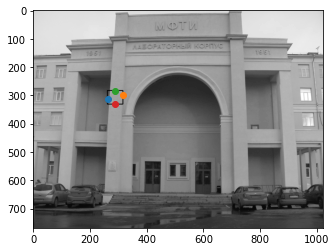

In [44]:
print(leftmost, rightmost,'\n', topmost, bottommost)

plt.imshow(img, cmap='gray')
plt.scatter(leftmost[0], leftmost[1])
plt.scatter(rightmost[0], rightmost[1])
plt.scatter(topmost[0], topmost[1])
plt.scatter(bottommost[0], bottommost[1]);